In [46]:
from blackjackenv import BlackjackEnv
from collections import defaultdict
from qagent import QAgent

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym


env = BlackjackEnv(sab=True, win_reward=4.0, lose_reward=-0.5, hit_reward=2.0)

In [47]:
# hyperparameters
learning_rate = 0.4
n_episodes = 10_000
start_epsilon = 0.5
epsilon_decay = start_epsilon / n_episodes  # reduce the exploration over time
final_epsilon = 0.05
gamma = 0.9

def initiate_50_agents(exp_policy, learning_rate, start_epsilon, epsilon_decay, final_epsilon, gamma):
    agents = []
    
    for i in range(0,50):
        agent = QAgent(
            exp_policy=exp_policy,
            alpha=learning_rate,
            initial_epsilon=start_epsilon,
            epsilon_decay=epsilon_decay,
            final_epsilon=final_epsilon,
            gamma=gamma
        )
        agents.append(agent)
    return agents

In [48]:
softmax_agents = initiate_50_agents("softmax", learning_rate, start_epsilon, epsilon_decay, final_epsilon, gamma)

In [49]:
greedy_agents = initiate_50_agents("greedy", learning_rate, start_epsilon, epsilon_decay, final_epsilon, gamma)

In [50]:
e_greedy_agents = initiate_50_agents("e_greedy", learning_rate, start_epsilon, epsilon_decay, final_epsilon, gamma)

In [35]:
def train_agents(agents):
    envs = []
    for agent in agents:
        env = BlackjackEnv(sab=True, win_reward=4.0, lose_reward=-0.5, hit_reward=2.0)
        env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
        for episode in tqdm(range(n_episodes)):
            state, info = env.reset()
            done = False
    
            # play one episode
            while not done:
                action = agent.get_action(state)
                next_state, reward, terminated, truncated, info = env.step(action)
    
                # update the agent
                agent.update(state, action, reward, terminated, next_state)
    
                # update if the environment is done and the current obs
                done = terminated or truncated
                state = next_state
    
            agent.decay_epsilon()
        envs.append(env)
    return envs

In [36]:
envs_softmax = train_agents(softmax_agents)
envs_greedy = train_agents(greedy_agents)
envs_e_greedy = train_agents(e_greedy_agents)

100%|██████████| 10000/10000 [00:03<00:00, 2977.05it/s]


In [8]:
# Durchschnittlicher Reward für jeweils 100 Spiele
averages = []
for env in envs:
    avg = []
    for i in range(100,1100,100):
        a = np.mean(np.array(env.return_queue).flatten()[i-100:i])
        avg.append(a)
    averages.append(avg)
    
rewards = []
for i in range(len(averages[0])):
    avg = []
    for j in range(len(averages)):
        m = averages[j][i]
        avg.append(m)
    rewards.append(np.mean(avg))

print(rewards) # ergibt 10 Durchschnitte aus jeweils dem Durchschnitt von 100 Spielen von 50 Agents

NameError: name 'envs' is not defined

In [37]:
def calculate_avg_reward(envs, rolling_length):
    rolling_length = rolling_length # mit 100 ergibt pro agent (env) 901 Datendurchschnitte
    avg = []
    for env in envs:
        reward_average = (
            np.convolve(
                np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
            )
            / rolling_length
        )
        avg.append(reward_average)
    
    avg_50_agents_100_games = []
    for i in range(len(avg[0])):
        a = []
        for j in range(len(avg)):
            m = avg[j][i]
            a.append(m)
        avg_50_agents_100_games.append(np.mean(a))
    
    return avg_50_agents_100_games
    # ergibt 901 Durchschnitte aus jeweils Durchschnitten von 50 Agents und immer 100 Spielen (100 immer um eine Stelle weiter geschoben - siehe unten)

In [38]:
softmax_rewards = calculate_avg_reward(envs_softmax, 1_000)
greedy_rewards = calculate_avg_reward(envs_greedy, 1_000)
e_greedy_rewards = calculate_avg_reward(envs_e_greedy, 1_000)

In [76]:
env = envs[0]

t = [5, 10, 4, 8, 9, 8]
print(np.mean(t[:3])) # 5, 10, 4
print(np.mean(t[1:4])) # 10, 4, 8
print(np.mean(t[2:5])) # 4, 8, 9
print(np.mean(t[3:6])) # 8, 9 , 8
np.convolve(
    np.array(t).flatten(), np.ones(3), mode="valid"
) / 3 # one das geteilt durch wird einfach addiert


6.333333333333333
7.333333333333333
7.0
8.333333333333334


array([6.33333333, 7.33333333, 7.        , 8.33333333])

In [61]:
print(np.mean(np.array(env.return_queue).flatten()[:100]))
print(np.mean(np.array(env.return_queue).flatten()[100:200]))
print(np.mean(np.array(env.return_queue).flatten()[200:300]))
print(np.mean(np.array(env.return_queue).flatten()[300:400]))
print(np.mean(np.array(env.return_queue).flatten()[400:500]))
print(np.mean(np.array(env.return_queue).flatten()[500:600]))
print(np.mean(np.array(env.return_queue).flatten()[600:700]))
print(np.mean(np.array(env.return_queue).flatten()[700:800]))
print(np.mean(np.array(env.return_queue).flatten()[800:900]))
print(np.mean(np.array(env.return_queue).flatten()[900:]))

-0.17
-0.11
-0.1
-0.26
-0.03
-0.2
-0.33
-0.41
-0.3
-0.09


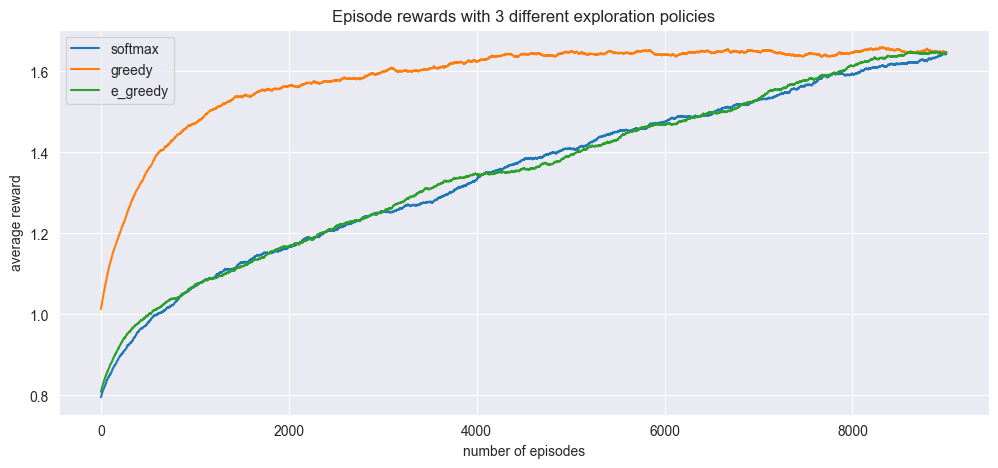

In [39]:
fig, axs = plt.subplots(figsize=(12, 5))
axs.set_title("Episode rewards with 3 different exploration policies")
axs.plot(range(len(softmax_rewards)), softmax_rewards, label = "softmax")
axs.plot(range(len(greedy_rewards)), greedy_rewards, label = "greedy")
axs.plot(range(len(e_greedy_rewards)), e_greedy_rewards, label = "e_greedy")
plt.legend()
plt.xlabel("number of episodes")
plt.ylabel("average reward")
plt.show()

In [40]:
a = [e_greedy_agents, greedy_agents, softmax_agents]
wins = []
for agents in a:
    env = BlackjackEnv(sab=True, win_reward=4.0, lose_reward=-0.5, hit_reward=2.0)
    for i in range(1,4):
        agent = agents[i]
        win = 0
        for episode in tqdm(range(n_episodes)):
            state, info = env.reset()
            done = False
        
            while not done:
                action = agent.get_action(state)
                next_state, reward, terminated, truncated, info = env.step(action)
            
                done = terminated or truncated
                state = next_state
                if reward == 4.0:
                    win += 1
        wins.append(win)

100%|██████████| 10000/10000 [00:02<00:00, 4721.84it/s]


In [41]:
policies = ["e_greedy", "greedy", "softmax"]
for i in range(0,9,3):
    policy = policies[int(i/3)]
    sum = 0
    for j in range(i,3+i):
        sum = sum + (wins[j]/n_episodes)
    avg = sum/3
    print("{} : {}%".format(policy,avg))

e_greedy : 0.02376666666666667%
greedy : 0.044366666666666665%
softmax : 0.0175%
